Note that with the code above one cannot directly input a video and receive a classification label of compressed or double compressed. This could be achieved by saving a preffered model (python pickle). After a new video is given by the user, features can be extracted and summarized as below for classification. 

# Press run cell button to run the H.265 classification pipeline 

In [1]:
!pip install -q gitpython
import os
import pandas as pd
from git import Repo

# Clone the GitHub repository
repo_url = 'https://github.com/c1scott/doublecompression'
repo_path = 'doublecompression'
Repo.clone_from(repo_url, repo_path)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.3 MB/s eta 0:00:00


<git.repo.base.Repo '/content/doublecompression/.git'>

Mean cross-validation score: 0.8051249494143714, standard deviation: 0.0019798686929572385
modified_double_tos-1720x720-cfg01_compressed_frame_info_csv.csv: 4023 misclassified entries
modified_double_ShakeNDry_3840x2160_120fps_420_8bit_HEVC_MP4_compressed_frame_info_csv.csv: 49 misclassified entries
modified_double_Rogue One - A Star Wars Story - HEVC Teaser_compressed_frame_info_csv.csv: 922 misclassified entries
modified_single_Toy Story 4 - Theatrical Trailer_frame_info_csv.csv: 581 misclassified entries
modified_double_bbb-1920x1080-cfg06_compressed_frame_info_csv.csv: 6552 misclassified entries
modified_double_bbb-1920x1080-cfg02_compressed_frame_info_csv.csv: 6093 misclassified entries
modified_single_X-Men - Apocalypse - Trailer 3 (HEVC)_frame_info_csv.csv: 937 misclassified entries
modified_double_Aladdin - Trailer 2_compressed_frame_info_csv.csv: 1464 misclassified entries
modified_double_Jockey_3840x2160_120fps_420_8bit_HEVC_MP4_compressed_frame_info_csv.csv: 225 misclassifie

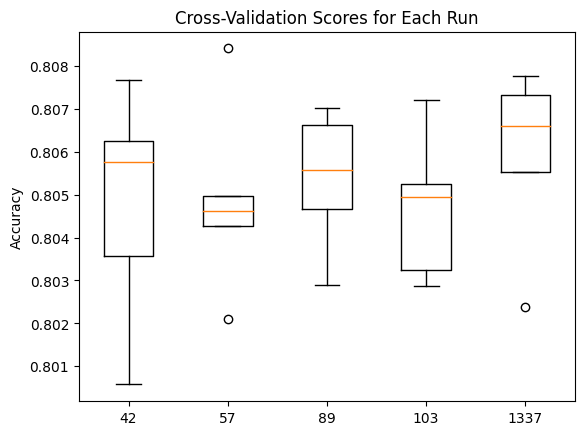

Misclassified CSV files:


In [7]:
# imports rest of necessary libraries 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Define utility functions

# Mapping of possible frame types within video/jsons of features to numerical values 
def map_first_col(val):
    return {"I": 0, "P": 1, "B": 2}.get(val, val)

# This function processes CSV files in a given folder by mapping their first columns and adding a "label" column.
# If a file name starts with "single", it is labeled as "single compressed", and if it starts with "double", 
# it is labeled as "double compressed". The processed DataFrames are saved to new CSV files with a "modified_" 
# prefix in the same folder

def process_csv_files(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            if filename.startswith("single"):
                label = "single compressed"
            elif filename.startswith("double"):
                label = "double compressed"
            else:
                continue

            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            df.iloc[:, 0] = df.iloc[:, 0].apply(map_first_col)
            df['label'] = label
            df.to_csv(os.path.join(folder_path, f"modified_{filename}"), index=False)

# This function prepares a dataset from CSV files in a given folder by concatenating DataFrames with "modified_" 
# prefix, splitting the data into features and labels, and performing a train-test split with a test size of 0.2 
# and a random seed of 42. It returns the split data.

def prepare_dataset(folder_path):
    dataframes = []
    for filename in os.listdir(folder_path):
        if filename.startswith("modified"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            dataframes.append(df)
    dataset = pd.concat(dataframes, ignore_index=True)
    X = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, -1].values
    return train_test_split(X, y, test_size=0.2, random_state=42)

def prepare_file_dataset(folder_path):
    data = []
    for filename in os.listdir(folder_path):
        if filename.startswith("modified"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            label = "single compressed" if filename.startswith("modified_single") else "double compressed"
            data.append((df.iloc[:, :-1].values, label, filename))
    return data

def classify_files(X_train, y_train, file_data):
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    rf.fit(X_train, y_train)
    results = []
    for X, true_label, file_name in file_data:
        y_pred = rf.predict(X)
        majority_label = "single compressed" if np.count_nonzero(y_pred == "single compressed") > np.count_nonzero(y_pred == "double compressed") else "double compressed"
        is_correct = majority_label == true_label
        misclassified_count = np.count_nonzero(y_pred != true_label)
        results.append((file_name, true_label, majority_label, is_correct, misclassified_count))
    return results

def evaluate_model_with_cross_val(X, y, cv=5):
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    scores = cross_val_score(rf, X, y, cv=cv)
    return scores

def plot_boxplot(scores, labels=None, title=None):
    plt.boxplot(scores, labels=labels)
    plt.ylabel('Accuracy')
    if title is not None:
        plt.title(title)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels=None, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    if title is not None:
        plt.title(title)
    plt.show()


# Process the CSV files
folder_path = "/content/doublecompression/265 output"
process_csv_files(folder_path)

# Prepare the dataset by adding a new column with the true label of the row's class
file_data = prepare_file_dataset(folder_path)

X_train, X_test, y_train, y_test = prepare_dataset(folder_path)


# Evaluate the model using cross-validation and find the best model
best_model = None
best_score = -1
random_seeds = [42, 57, 89, 103, 1337]
all_scores = []
for seed in random_seeds:
    seed_scores = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train_index, val_index in cv.split(X_train, y_train):
        X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
        y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

        rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        rf.fit(X_train_cv, y_train_cv)

        score = rf.score(X_val_cv, y_val_cv)
        seed_scores.append(score)

        if score > best_score:
            best_score = score
            best_model = rf
    all_scores.append(seed_scores)

mean_score = np.mean(all_scores)
std_score = np.std(all_scores)
print(f"Mean cross-validation score: {mean_score}, standard deviation: {std_score}")

# Use the best model to predict on the test set
y_pred = best_model.predict(X_test)


# Classify files and count misclassified entries within files
results = classify_files(X_test, y_test, file_data)
misclassified_file_counts = {}
for result in results:
    file_name = result[0]
    misclassified_count = result[-1]
    misclassified_file_counts[file_name] = misclassified_file_counts.get(file_name, 0) + misclassified_count

# Print the number of misclassified entries for each file
for file_name, count in misclassified_file_counts.items():
    print(f"{file_name}: {count} misclassified entries")

# Plot the boxplot of cross-validation scores
plot_boxplot(all_scores, labels=[str(seed) for seed in random_seeds], title='Cross-Validation Scores for Each Run')

# Print misclassified CSV files
misclassified_files = []
for result in results:
    if not result[3]:  # if is_correct is False
        misclassified_files.append(result[0])
print("Misclassified CSV files:")
for file in misclassified_files:
    print(file)


Misclassified CSV files:


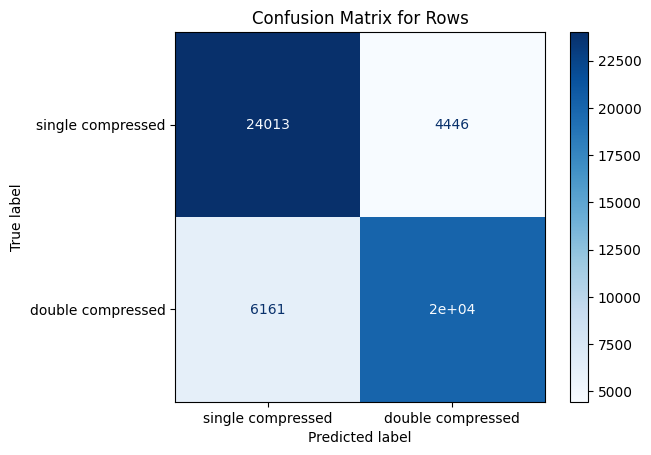

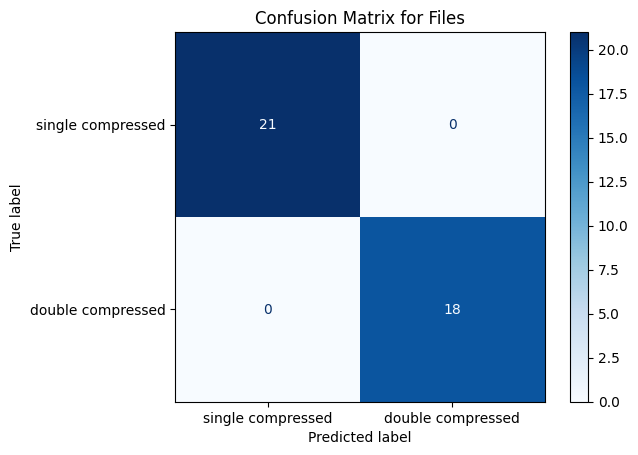

In [8]:
# Print misclassified CSV files
# empty indicates zero - need a larger training-test set to actually validate this performance 
misclassified_files = []
for result in results:
    if not result[3]:  # if is_correct is False
        misclassified_files.append(result[0])
print("Misclassified CSV files:")
for file in misclassified_files:
    print(file)

# Output a confusion matrix for rows
plot_confusion_matrix(y_test, y_pred, labels=["single compressed", "double compressed"], title="Confusion Matrix for Rows")

# Output a confusion matrix for files
true_labels_files = [result[1] for result in results]
predicted_labels_files = [result[2] for result in results]
plot_confusion_matrix(true_labels_files, predicted_labels_files, labels=["single compressed", "double compressed"], title="Confusion Matrix for Files")


# Code below for reference purposes

contains feature extraction pipeline, was ran locally

 A Python script that compresses video files in a given input folder and saves the compressed files in a specified output folder. The script uses the FFmpeg command-line tool to perform the compression. It supports various video file formats, such as MP4, AVI, MOV, MKV, and WMV. The compression settings include the libx264 video codec, a Constant Rate Factor (CRF) of 5 for high-quality output, a slow encoding speed for better compression ratio, and the AAC audio codec with a bitrate of 128 kbps.

In [ ]:
# Import necessary libraries
import os
import subprocess
from pathlib import Path

# Set the input and output folder paths
input_folder = Path('C:/Users/q42/Downloads/clips trailers h265/')
output_folder = Path('C:/Users/q42/Downloads/clips trailers h265/slowcrf15')

# Create the output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# List of supported video file extensions
video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv']

# Iterate through files in the input folder
for filename in input_folder.iterdir():
    # Check if the file has a supported video extension
    if filename.suffix.lower() in video_extensions:
        # Set the input and output file paths
        input_path = filename
        output_path = output_folder / f"{filename.stem}_compressed.mp4"
        
        # Create the command to compress the video using FFmpeg
        command = [
            "ffmpeg",
            "-i", str(input_path),                # Input file path
            "-c:v", "libx265",                    # Video codec (changed to libx265 for h265 encoding)
            "-crf", "15",                         # Constant Rate Factor (lower value = higher quality)
            "-preset", "slow",                    # Encoding speed and compression ratio
            "-c:a", "aac",                        # Audio codec
            "-b:a", "128k",                       # Audio bitrate
            str(output_path)                      # Output file path
        ]
        
        # Run the FFmpeg command to compress the video
        subprocess.run(command)


This Python code extracts frame information from video files using the ffprobe tool and saves the frame information in JSON format in a separate file for each input video file. It iterates through all files in the input folder, checks if each file has a supported video extension, and if so, constructs a ffprobe command to extract the frame information from the video file. It then executes the ffprobe command and saves the JSON output to a file in the output folder with a name based on the input file name. Finally, it prints a message indicating that the frame information was extracted and saved for the input video file and the location of the output file. This code can be used to extract frame information from video files for further analysis or processing.

In [ ]:
import subprocess
from pathlib import Path
import glob

input_folder = Path('C:/Users/q42/Downloads/clips trailers h265/')
output_folder = Path('C:/Users/q42/Downloads/clips trailers h265/frame_info')

# Create the output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# List of supported video file extensions
video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv']

# Iterate through files in the input folder
for video_file in input_folder.iterdir():
    # Check if the file has a supported video extension
    if video_file.suffix.lower() in video_extensions:
        # Set the output file path
        output_path = output_folder / f"{video_file.stem}_frame_info.json"

        # Extract frame information to a JSON file
        extract_frame_info_command = [
            "ffprobe",
            "-v", "quiet",
            "-print_format", "json",
            "-show_frames",
            "-select_streams", "v",
            "-i", str(video_file)
        ]

        with open(output_path, "w") as output_file:
            subprocess.call(extract_frame_info_command, stdout=output_file, stderr=subprocess.STDOUT)

        # Print a message indicating that the file was processed
        print(f"Frame information extracted for {video_file} and saved to {output_path}")


The Python code extracts specific fields from JSON files containing frame information for videos and saves the extracted data as CSV files. The code iterates through all JSON files in a specified folder and extracts the frames and certain fields from each JSON file. It then creates a new CSV file with the same name as the JSON file and writes the extracted data to the CSV file

In [ ]:
import json
import csv
from pathlib import Path

# Set the folder path containing the JSON files
output_folder = Path('C:/Users/q42/Downloads/clips trailers h265/slowcrf15/frame_info_recompressed')

# Specify the fields to extract from the JSON
fields = [
    "pict_type",
    "pkt_size",
    "pkt_pos",
    "key_frame",
]

# Iterate through files in the output_folder
for json_path in output_folder.glob('*.json'):
    # Load the JSON data from a file
    with open(json_path, "r") as json_file:
        data = json.load(json_file)

    # Extract the frames from the JSON data
    frames = data["frames"]

    # Create a CSV file and write the extracted data
    csv_path = json_path.with_suffix('.csv')
    with open(csv_path, "w", newline="") as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=fields)
        writer.writeheader()

        for frame in frames:
            if frame["media_type"] == "video":
                # Extract the specified fields from the frame
                row_data = {field: frame[field] for field in fields}
                writer.writerow(row_data)

    print(f"CSV file created successfully: {csv_path}")


This Python code extracts specific keys from JSON files containing frame information for compressed and recompreesed videos (no splicing/editing/authenticity changes done, only integrity altered), creates CSV files with the extracted data, and stores them in a specified output folder.

In [ ]:
import os
import json
import csv

single_comp_folder = "C:/Users/q42/Downloads/clips trailers h265/data/frame_info"
double_comp_folder = "C:/Users/q42/Downloads/clips trailers h265/data/frame_info_recompressed"
output_folder = "C:/Users/q42/Downloads/clips trailers h265/data/output"

# Define the keys to extract
keys = ['pict_type', 'pkt_size', 'pkt_pos', 'key_frame']

folders = [single_comp_folder, double_comp_folder]

for folder in folders:
    # Loop over all files in the folder
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if not os.path.isfile(file_path) or not filename.endswith('.json'):
            continue

        # Open the JSON file and load the data
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Extract the entries for the desired keys from all frames
        rows = []
        for frame in data['frames']:
            row = [frame.get(key) for key in keys]
            rows.append(row)

        # Write the output CSV file
        folder_prefix = "single" if folder == single_comp_folder else "double"
        output_csv_filename = f"{folder_prefix}_{filename[:-5]}_csv.csv"
        output_csv_path = os.path.join(output_folder, output_csv_filename)
        with open(output_csv_path, 'w', newline='') as output_csv_file:
            writer = csv.writer(output_csv_file)
            writer.writerow(keys)
            writer.writerows(rows)


The code prepares data from CSV files containing packet information, labels the data as single or double compressed based on the file name, runs a classification experiment using Random Forest algorithm on the data, and stores the validation and test accuracies obtained from 5 different runs with different seeds. Finally, it plots a boxplot of the accuracies.

In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def run_experiment(X, y, seed):
    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

    # Preprocess the data (scaling)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Choose a classification algorithm
    clf = RandomForestClassifier(n_estimators=100, random_state=seed)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Test the classifier on validation set
    y_val_pred = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Test the classifier on test set
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    return val_accuracy, test_accuracy

output_folder = "C:/Users/q42/Downloads/clips trailers h265/data/output"

# Prepare the data
X = []  # Features
y = []  # Labels

for filename in os.listdir(output_folder):
    if not filename.endswith('_csv.csv'):
        continue

    label = 1 if filename.startswith('double') else 0

    with open(os.path.join(output_folder, filename), 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header

        for row in reader:
            pkt_size, pkt_pos, key_frame = int(row[1]), int(row[2]), int(row[3])
            X.append([pkt_size, pkt_pos, key_frame])
            y.append(label)

X = np.array(X)
y = np.array(y)

# Run the experiment 5 times with different seeds and store the results
results = [run_experiment(X, y, seed=i) for i in range(5)]

# Extract validation and test accuracies
val_accuracies, test_accuracies = zip(*results)

# Plot the boxplots
plt.boxplot([val_accuracies, test_accuracies])
plt.title('Validation and Test Accuracies over 5 Runs with Different Seeds')
plt.ylabel('Accuracy')
plt.xticks([1, 2], ['Validation', 'Test'])
plt.show()


deprecated

In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def run_experiment(X, y, seed):
    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

    # Preprocess the data (scaling)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

     # Perform a parameter search for the SVM
    param_dist = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.1, 1, 10, 100],
    }
    svm = SVC(kernel='rbf')
    clf = RandomizedSearchCV(svm, param_dist, n_iter=16, cv=5, n_jobs=-1, random_state=seed)
    print(f"Running RandomizedSearchCV for run {seed + 1}")
    clf.fit(X_train, y_train)

    # Use the best parameters on validation set
    y_val_pred = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Use the best parameters on test set
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    return val_accuracy, test_accuracy

output_folder = "C:/Users/q42/Downloads/clips trailers h265/data/output"

# Prepare the data
X = []  # Features
y = []  # Labels

for filename in os.listdir(output_folder):
    if not filename.endswith('_csv.csv'):
        continue

    label = 1 if filename.startswith('double') else 0

    with open(os.path.join(output_folder, filename), 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header

        for row in reader:
            pkt_size, pkt_pos, key_frame = int(row[1]), int(row[2]), int(row[3])
            X.append([pkt_size, pkt_pos, key_frame])
            y.append(label)

X = np.array(X)
y = np.array(y)


# Run the experiment 5 times with different seeds and store the results
results = []
for i in range(5):
    val_accuracy, test_accuracy = run_experiment(X, y, seed=i)
    results.append({
        'run': i + 1,
        'validation_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    })
    print(f"Run {i + 1}: Validation Accuracy = {val_accuracy}, Test Accuracy = {test_accuracy}")


# Extract validation and test accuracies
val_accuracies, test_accuracies = zip(*results)

# Plot the boxplots
plt.boxplot([val_accuracies, test_accuracies])
plt.title('Validation and Test Accuracies over 5 Runs with Different Seeds')
plt.ylabel('Accuracy')
plt.xticks([1, 2], ['Validation', 'Test'])
plt.show()
